In [27]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Modules imported.')

Modules imported.


# Import and parse the dataset

### Split pickup and dropoff columns to corresponding date and time columns

In [3]:
# reading in the dataset
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

All the following data manipulation could be accomplished with Pandas Dataframe methods:

In [4]:
# defining different columns for date and time
train['pickup_date'], train['pickup_time'] = zip(*train['pickup_datetime'].apply(lambda x: x.split(' ')))
train['dropoff_date'], train['dropoff_time'] = zip(*train['dropoff_datetime'].apply(lambda x: x.split(' ')))

In [5]:
# splitting 'date' column by corresponding values
pickup_date_year, pickup_date_month, pickup_date_day = zip(*train['pickup_date'].apply(lambda x: x.split('-')))
dropoff_date_year, dropoff_date_month, dropoff_date_day = zip(*train['dropoff_date'].apply(lambda x: x.split('-')))

In [6]:
pickup_date_month = pd.to_numeric(pickup_date_month)
pickup_date_day = pd.to_numeric(pickup_date_day)

dropoff_date_month = pd.to_numeric(dropoff_date_month)
dropoff_date_day = pd.to_numeric(dropoff_date_day)

In [7]:
# converting months into days and creating separate columns
pickup_days = (pickup_date_month * 30) + pickup_date_day
dropoff_days = (dropoff_date_month * 30) + dropoff_date_day

train['pickup_days'] = pickup_days
train['dropoff_days'] = dropoff_days

In [8]:
# taking only hours from hh.mm.ss
pickup_hours = pd.to_numeric(train.pickup_time.str.slice(0, 2))
dropoff_hours = pd.to_numeric(train.dropoff_time.str.slice(0, 2))

train['pickup_hours'] = pickup_hours
train['dropoff_hours'] = dropoff_hours

In [9]:
# binary encoding of fwd_falg colums
fwd_flag = pd.get_dummies(train.store_and_fwd_flag).iloc[:,1]
train['fwd_flag'] = fwd_flag

In [10]:
# creating features and label variables
X = pd.DataFrame(data=train, columns=['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_days', 'dropoff_days', 'pickup_hours', 'dropoff_hours', 'fwd_flag'])
y = pd.DataFrame(data=train, columns=['trip_duration'])

In [10]:
X.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_days,dropoff_days,pickup_hours,dropoff_hours,fwd_flag
0,2,1,-73.982155,40.767937,-73.964630,40.765602,104,104,17,17,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,192,192,0,0,0
2,2,1,-73.979027,40.763939,-74.005333,40.710087,49,49,11,12,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,126,126,19,19,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,116,116,13,13,0


### Visualizations

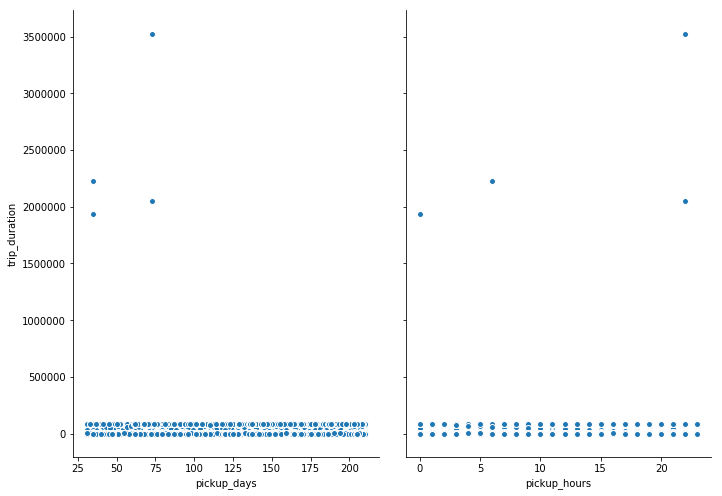

In [18]:
sns.pairplot(train, x_vars=['pickup_days', 'pickup_hours'], y_vars='trip_duration', size=7, aspect=0.7, kind='reg')

# Splitting the dataset into train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

# Feature scaling

### Standardization

In [12]:
scaler = preprocessing.StandardScaler().fit(X)

In [13]:
X = scaler.transform(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# converting standardized values into a dataframe
X = pd.DataFrame(X)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Algorithms and results

## Linear Regression

In [14]:
# initializing a linear regressor
lr = LinearRegression(normalize=True)

In [16]:
# cross-validation with a linear regression
scores = cross_val_score(lr, X, y, cv=10, scoring='r2')
print('Cross-validation score on dataset:', scores.mean())

Cross-validation score on dataset: 0.783393337107


In [21]:
# training and testing the algorithm on a single split
lr_fit = lr.fit(X_train, y_train)

In [22]:
lr_pred = lr.predict(X_test)

In [17]:
print('Coefficients: \n', lr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, lr_pred))
# explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, lr_pred))

Coefficients: 
 [[  1.19741383e+01  -1.93494971e-01   2.12906522e+01  -1.64060420e+01
   -3.76607043e+00  -9.35706111e+00  -3.92667254e+06   3.92674458e+06
   -2.03597998e+04   2.06311763e+04   7.37796745e-01]]
Mean squared error: 2736449.32
Variance score: 0.89


## KNN Regression

In [14]:
# initializing a knn regressor
neigh = KNeighborsRegressor(n_neighbors=1)

In [24]:
# search grid parameters
k_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_grid_neigh = dict(n_neighbors=k_range)

In [25]:
# creating a search grid for the knn regressor
grid_neigh = GridSearchCV(neigh, param_grid_neigh, cv=10, scoring='r2')

In [26]:
# training
grid_neigh.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [32]:
grid_neigh_mean_scores = [result.mean_validation_score for result in grid_neigh.grid_scores_]
print(grid_neigh_mean_scores)

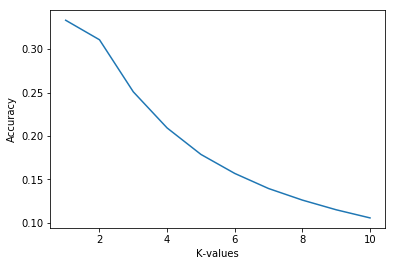

In [34]:
plt.plot(k_range, grid_neigh_mean_scores)
plt.xlabel('K-values')
plt.ylabel('Accuracy')

In [ ]:
# training and testing the algorithm on a single split
neigh_fit = neigh.fit(X_train, y_train)
neigh_pred = neigh.predict(X_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, neigh_pred))
# explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, neigh_pred))

# Support Vector Regression

In [14]:
# initializing an svr
svr = LinearSVR(loss='squared_epsilon_insensitive')

In [15]:
# search grid parameters
param_grid_svr = [{'C': [1, 0.1], 'epsilon': [0.1, 0]}]

In [16]:
# creating a search grid for the svr
grid_svr = GridSearchCV(svr, param_grid_svr, cv=10, scoring='r2')

In [17]:
# training
grid_svr.fit(X, y.squeeze(1))

GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'epsilon': [0.1, 0], 'C': [1, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [27]:
grid_svr_mean_scores = [score for score in grid_svr.grid_scores_]
print(grid_svr_mean_scores)

[mean: 0.73468, std: 0.03964, params: {'epsilon': 0.1, 'C': 1}, mean: 0.73468, std: 0.03962, params: {'epsilon': 0, 'C': 1}, mean: 0.26695, std: 0.03387, params: {'epsilon': 0.1, 'C': 0.1}, mean: 0.26637, std: 0.03447, params: {'epsilon': 0, 'C': 0.1}]


/home/gusein/Programs/anaconda3/envs/nyc-taxi/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# XGBoost Decision Trees

In [12]:
# initializing an xgb
xgb = XGBRegressor()

In [13]:
# search grid parameters
param_grid_xgb = [{'max_depth': [5], 'learning_rate': [1, 2], 'n_estimators': [500, 600]}]

In [14]:
# creating a search grid for the xgb
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=10)

In [ ]:
# training
grid_xgb.fit(X, y)

In [19]:
print(grid_xgb.grid_scores_)

/home/gusein/Programs/anaconda3/envs/nyc-taxi/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.09333, std: 0.11374, params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100},
 mean: 0.20584, std: 0.14664, params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 300},
 mean: 0.10096, std: 0.10941, params: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100},
 mean: 0.23819, std: 0.12986, params: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 300},
 mean: -0.05480, std: 0.02634, params: {'max_depth': 3, 'learning_rate': 0.001, 'n_estimators': 100},
 mean: -0.03287, std: 0.01588, params: {'max_depth': 3, 'learning_rate': 0.001, 'n_estimators': 300},
 mean: -0.05443, std: 0.02616, params: {'max_depth': 4, 'learning_rate': 0.001, 'n_estimators': 100},
 mean: -0.03133, std: 0.01499, params: {'max_depth': 4, 'learning_rate': 0.001, 'n_estimators': 300}]

# Random Forest Regression

In [16]:
# initializing a random forest regressor
rfor = RandomForestRegressor(max_features='sqrt', n_estimators=20)

In [17]:
# search grid parameters
param_grid_rfor = [{'min_samples_leaf': [50, 60, 80]}]

In [20]:
# creating a search grid for the xgb
grid_rfor = GridSearchCV(rfor, param_grid_rfor, cv=10)

In [21]:
# training
grid_rfor.fit(X, y.squeeze(1))

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'min_samples_leaf': [50, 60, 80]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
print(grid_rfor.grid_scores_)

/home/gusein/Programs/anaconda3/envs/nyc-taxi/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.02490, std: 0.01179, params: {'min_samples_leaf': 50},
 mean: 0.02494, std: 0.01166, params: {'min_samples_leaf': 60},
 mean: 0.02539, std: 0.01204, params: {'min_samples_leaf': 80}]

# Bayesian Ridge

In [20]:
# initializing a bayesian ridge
br = BayesianRidge()

In [23]:
# training and testing the algorithm on a single split
br.fit(X_train, y_train.squeeze(1))

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [26]:
br_pred = br.predict(X_test)

In [27]:
print('Coefficients: \n', br.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, br_pred))
# explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, br_pred))

Coefficients: 
 [  1.11156230e+01  -5.31337996e-01   2.35761359e+01  -1.81180158e+01
  -5.23730043e+00  -8.78161808e+00  -3.94096102e+06   3.94103280e+06
  -2.04347823e+04   2.07070203e+04   1.00759262e+00]
Mean squared error: 3011187.88
Variance score: 0.88


In [21]:
# search grid parameters
param_grid_br = [{'n_iter': [300, 500]}]

In [22]:
# creating a search grid for the bayesian ridge
grid_br = GridSearchCV(br, param_grid_br, cv=10)

In [23]:
# training the model with a grid search and cross-validation
grid_br.fit(X, y.squeeze(1))

GridSearchCV(cv=10, error_score='raise',
       estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_iter': [300, 500]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [24]:
print(grid_br.grid_scores_)

/home/guseyn/Programs/conda/envs/nyc-taxi/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.78339, std: 0.10064, params: {'n_iter': 300},
 mean: 0.78339, std: 0.10064, params: {'n_iter': 500}]

## Neural Network

In [29]:
# initializing a nn
nn = MLPRegressor(batch_size=40, verbose=True)

In [30]:
# search grid parameters
param_grid_nn = [{'max_iter': [200, 400], 'learning_rate_init': [0.01, 0.001, 0.0001]}]

In [32]:
# creating a search grid for the nn
grid_nn = GridSearchCV(nn, param_grid_nn)

In [ ]:
# training the model with a grid search and cross-validation
grid_nn.fit(X, y.squeeze(1))

Iteration 1, loss = 16051634.11286957
Iteration 2, loss = 16000823.77303024
Iteration 3, loss = 15998956.06632313
Iteration 4, loss = 15984292.37819044


/home/guseyn/Programs/conda/envs/nyc-taxi/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
